# Decision tree и Random forest

Реализовать 2 класса DecisionTreeClassifier и RandomForestClassifier

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.model_selection import KFold

In [84]:
gkf = KFold(n_splits=3, shuffle=True)

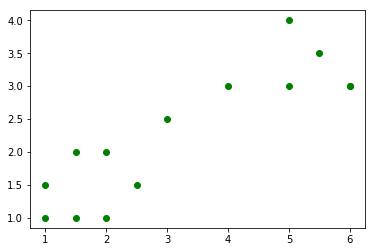

In [85]:
X = np.array([[1, 1], [1.5, 1], [1.5, 2], [1, 1.5], # 0
              [5.5, 3.5],                           # 1
              [2.5, 1.5],                           # 0
              [3, 2.5], [6, 3], [5, 3],             # 1
              [4, 3], [2, 1], [2, 2],               # 0
              [5, 4], [6, 3]])                      # 1
Y = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

plt.figure(1)
plt.plot(*zip(*X), marker='o', color=clr, ls='')
plt.show()

A = np.array([[1, 18, 88], [1, 22, 56], [0, 19, 78], [1, 11, 54], [0, 21, 76]])
B = np.array([1, 0, 1, 0, 1])

In [86]:
def splitByEdge(x, y, dim, edge, min_spl):
    xl, yl, xr, yr = [], [], [], []
    for i in range(x.shape[0]):
        if (x[i][dim] > edge):
            xr.append(list(x[i]))
            yr.append(y[i])
        else:
            xl.append(list(x[i]))
            yl.append(y[i])
    if (len(yl) < min_spl or len(yr) < min_spl):
        return None
    return np.array([[xl, yl],[xr, yr]])
            
tst = splitByEdge(X, Y, 1, 2.8, 1)
if (tst is not None):
    print tst[0][0]
    print tst[0][1]
    print tst[1][0]
    print tst[1][1]

def P(y, x_count, c_count, c_start):
    p = np.array([0.0 for yo in range(c_count)])
    for i in range(c_count):
        for it in y:
            if (it == i+c_start):
                p[i] += 1
    for i in range(c_count):
        p[i] /= x_count
    return p

def H(p, type='gini'):
    if (type == 'gini'):
        r = 2
        for i in p:
            r *= i
        return r
    elif (type == 'entropy'):
        r = 0
        for i in p:
            r -= i*np.log(i)
        return r
    else:
        return 1 - p.max()

def G(pl, pr, xl, xr, xo):
    kl = (xl + 0.0) / xo
    kr = (xr + 0.0) / xo
    return kl*H(pl) + kr*H(pr)

class TreeNode:
    def __init__(self, edge, attr, left, right):
        self.edge = edge
        self.attr = attr
        self.left = left
        self.right = right

class DecisionTreeClassifier():
    def __init__(self, max_depth=16, min_samples_split=2, count_split=10, rst=0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.count_split = count_split
        self.rst = rst
        self.c_count = 2
        self.c_start = 0
        self.x_count = 0
        self.bintree = None
        
    def tree(self, x, y, depth):
        if (depth > self.max_depth or x.shape[0] < 2 * self.min_samples_split or len(x.shape) <= 1):
            return None
        min_att = x.min(axis=0)
        max_att = x.max(axis=0)
        dim = depth % x.shape[1]
        l = min_att[dim]
        r = max_att[dim]
        s = (r - l) / self.count_split
        tk = 1.0
        te = (l + r) / 2
        for ed in np.arange(l, r+s, s):
            seg = splitByEdge(x, y, dim, ed, self.min_samples_split)
            if (seg is not None):
                pl = P(seg[0][1], self.x_count, self.c_count, self.c_start)
                pr = P(seg[1][1], self.x_count, self.c_count, self.c_start)
                xl = np.array(seg[0][0]).shape[0]
                xr = np.array(seg[1][0]).shape[0]
                tm = G(pl, pr, xl, xr, x.shape[0])
                if (tm < tk):
                    tk = tm
                    te = ed
        if (tk == 1.0):
            return None
        seg = splitByEdge(x, y, dim, te, self.min_samples_split)
        left = self.tree(np.array(seg[0][0]), np.array(seg[0][1]), depth+1)
        right = self.tree(np.array(seg[1][0]), np.array(seg[1][1]), depth+1)
        if (left is None):
            left = P(seg[0][1], self.x_count, self.c_count, self.c_start)
        if (right is None):
            right = P(seg[1][1], self.x_count, self.c_count, self.c_start)
        return TreeNode(te, dim, left, right)
        
        
    def fit(self, x, y):
        self.c_count = len(set(y))
        if (self.c_count > 2):
            print "Too many classes"
            return None
        self.c_start = y.min()
        self.x_count = x.shape[0]
        self.bintree = self.tree(x, y, 0)
        return self
                
    
    def solve(self, bt, elem):
        if (isinstance(bt, TreeNode)):
            if (elem[bt.attr] > bt.edge):
                return self.solve(bt.right, elem)
            else:
                return self.solve(bt.left, elem)
        else:
            if (bt[0] > bt[1]):
                return 0
            else:
                return 1
    
    def predict(self, x):
        y = np.array([self.c_start for i in range(x.shape[0])])
        if (self.bintree is None):
            print "Warning: No data or only one class!"
        else:
            for i in range(x.shape[0]): 
                y[i] = self.solve(self.bintree, x[i])
        return y
        
    
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X, Y)
clf.predict(X)

print "END"

#clf = DecisionTreeClassifier()
#clf.fit(A, B)
#clf.predict(A)

[[1.0, 1.0], [1.5, 1.0], [1.5, 2.0], [1.0, 1.5], [2.5, 1.5], [3.0, 2.5], [2.0, 1.0], [2.0, 2.0]]
[0, 0, 0, 0, 0, 1, 0, 0]
[[5.5, 3.5], [6.0, 3.0], [5.0, 3.0], [4.0, 3.0], [5.0, 4.0], [6.0, 3.0]]
[1, 1, 1, 0, 1, 1]
END


In [91]:
clf = DecisionTreeClassifier()

for train, test in gkf.split(X, Y):
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    
    clf.fit(X_train, Y_train)
    
    print clf.predict(X_test)
    print Y_test
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=Y_test))

[0 0 1 0 1]
[0 0 1 0 1]
1.0
[0 1 1 1 1]
[0 0 1 0 1]
0.6
[0 1 0 0]
[0 1 1 0]
0.75


In [89]:
class RandomForestClassifier():
    def __init__(self):
        pass
    def fit(self):
        pass
    def predict(self):
        pass
    def fit_predict(self):
        pass